In [1]:
import Environment
import parameters
pa = parameters.Parameters()
pa.num_nw = 5
pa.simulate_len = 50
pa.num_ex = 10
pa.new_job_rate = 1
pa.compute_dependent_parameters()
env = Environment.Allocation_Environment(pa, render=False, repre='image')
env.step(5)
env.step(5)
env.step(5)
env.step(5)
env.step(5)


Load On # 0 Resource Dimension Is  1.1594666666666666
Load On # 1 Resource Dimension Is  1.2198666666666667


(array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 -11.000000000000002,
 False,
 <Job.JobRecord at 0x1a692120610>)

In [3]:
job = env.job_backlog.backlog[0]


In [5]:
env.job_backlog.show()

+--------+------------+------------+------------+-------------+
| Job Id | Res Vector | Enter Time | Start Time | Finish Time |
+--------+------------+------------+------------+-------------+
|   1    |   [2 8]    |     2      |     -1     |      -1     |
|   2    |   [8 2]    |     3      |     -1     |      -1     |
|   2    |   [8 2]    |     3      |     -1     |      -1     |
|   3    |   [7 1]    |     4      |     -1     |      -1     |
|   3    |   [7 1]    |     4      |     -1     |      -1     |
|   3    |   [7 1]    |     4      |     -1     |      -1     |
|   4    |  [ 2 10]   |     5      |     -1     |      -1     |
|   4    |  [ 2 10]   |     5      |     -1     |      -1     |
|   4    |  [ 2 10]   |     5      |     -1     |      -1     |
|   4    |  [ 2 10]   |     5      |     -1     |      -1     |
+--------+------------+------------+------------+-------------+


In [ ]:
import numpy as np


In [ ]:
n

In [ ]:
import tensorflow
import gym
import pandas

In [ ]:
tensorflow.config.list_physical_devices()

In [ ]:
csv = pandas.read_csv("Sever.csv")

In [ ]:
ze =numpy.zeros([3,15])

In [ ]:
ze

In [ ]:
z1 = numpy.array([1,2,3])

In [ ]:
for i in range(1,100):
    on1 = numpy.ones([10])
    cpu = on1 * 10
    mem = on1 * 20
    numpy.concatenate([cpu,mem],axis=0).reshape([2,10])

In [ ]:
numpy.array([10,20]).repeat(10).reshape([2,10])

In [ ]:
request = [0,0]

In [ ]:
request.__len__()

In [ ]:
numpy.repeat(z1,15).reshape([z1.size,15])

In [ ]:
    class Server_State:
        # 剩余资源
        def __init__(self,server_def=[0,0],server_cost = [0,0], 
                            server_used = numpy.zeros([2,15]),time = 15) -> None:
            # 资源
            # 持有资源
            self.possess = numpy.array(server_def)
            # 已用资源
            self.used = server_used
            # 可用资源
            self.available = numpy.repeat(self.possess,time)\
                .reshape([self.possess.size,time]) - server_used
            self.cost = numpy.array(server_cost)
            pass
        def allocate(self,server_use = numpy.zeros([2,15])):
            self.available -= server_use
            print("{a}",self.available)

In [ ]:
st = Server_State([123,255],[1235,51555],numpy.ones([2,15]),15)

In [ ]:
st.allocate(numpy.ones([2,10])+numpy.zeros([2,15]))

In [ ]:
numpy.zeros([2,15])+numpy.ones([2,10])

In [ ]:
on1 = numpy.ones([2,10])

In [ ]:
numpy.concatenate((on1,numpy.zeros([2,5])),axis=1)

In [ ]:
st.available[0][0]

In [ ]:
a = [[0,1],[0]]
a[0].__len__()

In [ ]:
numpy.zeros([2,3])

In [ ]:
3*365

In [ ]:
73229/1095

In [ ]:
import numpy
a = numpy.zeros([4,5])
a.len

In [5]:
import job_distribution
dist = job_distribution.Dist(2,10,15)
nw_len,size = dist.bi_model_dist()
size


array([9., 2.])

In [1]:
import numpy as np
import Environment
env = Environment.Allocation_Environment()
env.nw_size_seq[0,0]

ValueError: could not broadcast input array from shape (2,) into shape (5,)

In [2]:
import sys
sys.path.append("..")

In [3]:
sys.path

['c:\\Users\\Yuming\\source\\repos\\ResMan',
 'C:\\Program Files\\Python311\\python311.zip',
 'C:\\Program Files\\Python311\\DLLs',
 'C:\\Program Files\\Python311\\Lib',
 'C:\\Program Files\\Python311',
 'c:\\Users\\Yuming\\source\\repos\\ResMan\\man',
 '',
 'c:\\Users\\Yuming\\source\\repos\\ResMan\\man\\Lib\\site-packages',
 'c:\\Users\\Yuming\\source\\repos\\ResMan\\man\\Lib\\site-packages\\win32',
 'c:\\Users\\Yuming\\source\\repos\\ResMan\\man\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\Yuming\\source\\repos\\ResMan\\man\\Lib\\site-packages\\Pythonwin',
 '..']

In [2]:
import parameters
import Environment
pa = parameters.Parameters()
env = Environment.Allocation_Environment(pa)


Load On # 0 Resource Dimension Is  0.6933333333333334
Load On # 1 Resource Dimension Is  1.7933333333333334


In [9]:
job = env.get_new_job_from_seq(0,0)
job.res_vec

array([1, 9])

In [3]:
import Environment
def test_image_representation():
    """
    Purpose: representation the job image
    """
    env = Environment.Allocation_Environment()
    return env.machine.canvas

In [5]:
canvas = test_image_representation()

Load On # 0 Resource Dimension Is  0.6933333333333334
Load On # 1 Resource Dimension Is  1.7933333333333334


In [8]:
canvas[1].shape

(20, 15)

In [1]:
[None] * 5

[None, None, None, None, None]

In [3]:
import numpy as np
canvas = np.zeros((2,10,10))

In [4]:
canvas[1,2,[0,2,3]]=0.3


In [5]:
canvas

array([[[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]],

       [[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.3, 0. , 0.3, 0.3, 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. ,

In [ ]:
import cpuPower
intel = cpuPower.INTELCPU()


In [33]:
intel.get_power()
intel.get_power()


24.70908949168137

In [6]:
import numpy as np
back = np.arange(0,10,1)

In [3]:
back[:-1]=back[1:]

In [4]:
back

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 9])

In [7]:
import numpy as np
max_nw_vec=[10, 20]
np.divide(np.array(max_nw_vec), 2)


array([ 5., 10.])

In [4]:
len([None] * 10)
 

10

(array([ 3., 14., 14., 18., 16., 13.,  8.,  8.,  4.,  2.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

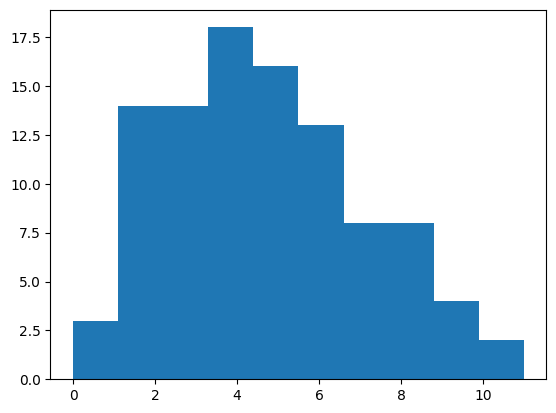

In [11]:
from scipy.stats import poisson
from collections import Counter
import matplotlib.pyplot as plt  # 
poi = poisson.rvs(5,size=100)
rctd = Counter(poi)
plt.hist(poi)
